# Heart Disease Classifier
Within this notebook we will perform classification on a dataset in order to predict whether someone is at high cardiovascular risk. The goal of this notebook is to create a classification model on this issue, in order to use this model in a web application. We'll be working along the steps of the data science lifecycle to achieve this goal.

## 1. Problem description and objective
**Problem description:** People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Objective:** Make a machine learning model that can predict whether someone is at high cardiovascular risk (binairy classification). 


## 2. Data acquisition
The data comes from the following kaggle [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data into a dataframe
df = pd.read_csv('heart.csv', sep=",")

## 3. Data exploration

In [2]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


**Attribute information**
- Age: 
        - age of the patient [years]
- Sex: 
        - sex of the patient [M: Male, F: Female]
- ChestPainType: 
        - chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: 
        - resting blood pressure [mm Hg]
- Cholesterol: 
        - serum cholesterol [mm/dl]
- FastingBS: 
        - fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: 
        - resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: 
        - maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: 
        - exercise-induced angina [Y: Yes, N: No]
- Oldpeak: 
        - oldpeak = ST [Numeric value measured in depression]
- ST_Slope: 
        - the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: 
        - output class [1: heart disease, 0: Normal]

In [4]:
# Checking for NULLs in the data
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

<AxesSubplot:>

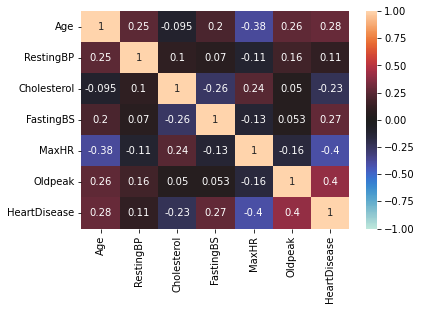

In [5]:
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0)

<AxesSubplot:>

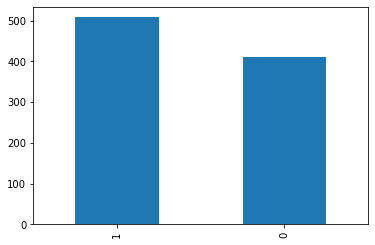

In [6]:
# See the distribution of the HeartDisease column, since this will be our y 
df['HeartDisease'].value_counts().plot(kind='bar')

## 4 Data preprocessing
We will use label encoding instead of one-hot encoding, since we're planning to use tree based algoritms.
We want to use these type of algoritms because they are very explainable, which is important for the ethical consideration of our model.


In [7]:
from sklearn.preprocessing import LabelEncoder

df = df.apply(LabelEncoder().fit_transform)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,12,1,1,41,147,0,1,98,0,10,2,0
1,21,0,2,55,40,0,1,82,0,20,1,1
2,9,1,1,31,141,0,2,25,0,10,2,0
3,20,0,0,39,72,0,1,34,1,25,1,1
4,26,1,2,49,53,0,1,48,0,10,2,0


In [8]:
# Shuffle the data
from sklearn.utils import shuffle
df = shuffle(df)

# Split the dataset into features (X) and target (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
             
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical columns
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Preprocessing using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

## 5. Modelling: Feature selection
For our model we chose not to remove any of the present features.

## 6. Modelling: Model training
We have chosen binary tree classification for our model to prioritize explainability in predicting cardiovascular risk. Explainability is crucial in this context because it empowers individuals to understand how and why a particular risk assessment was made. This transparency not only fosters trust in the model's predictions but also enables individuals to take informed actions to manage their cardiovascular health more effectively.

In [9]:
# Create a pipeline with preprocessing and model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier', DecisionTreeClassifier())])

## 7. Modelling: Model evalution

C:\Users\MJ\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Decision tree visualization saved as: decision_tree_visualization.svg


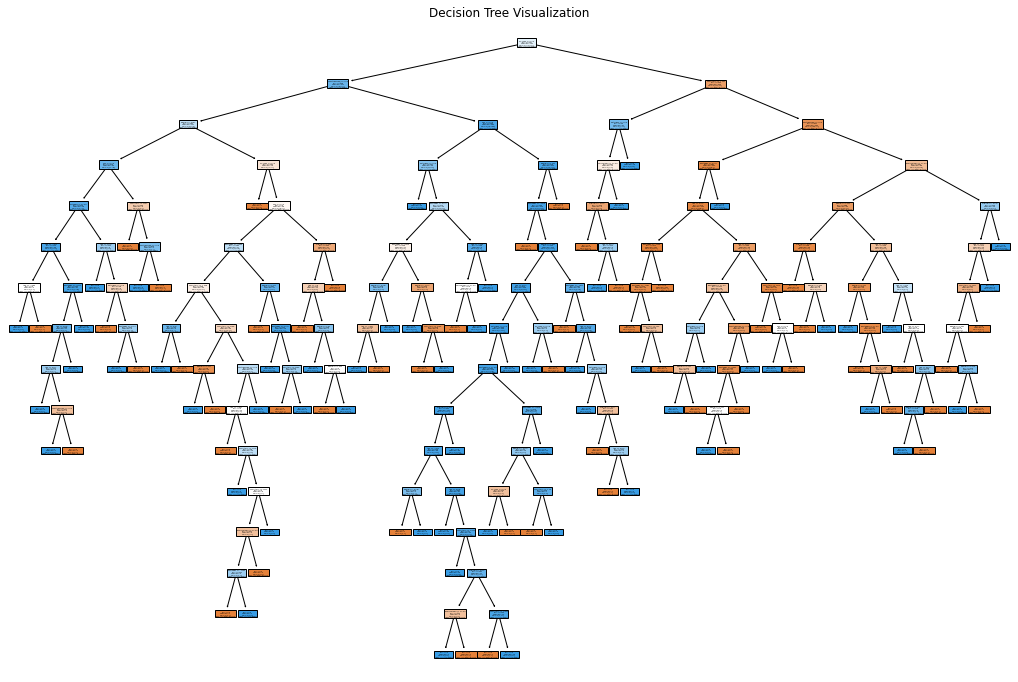

Accuracy: 0.81
Precision: 0.88
Recall: 0.81
F1 Score: 0.84


In [10]:
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get the transformed feature names from the preprocessor
transformed_feature_names = (
    model.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names(input_features=categorical_cols)
    .tolist()
)

# Combine the transformed feature names with numerical feature names
feature_names = numerical_cols + transformed_feature_names

# Visualize the decision tree and save it to as a svg
plt.figure(figsize=(18, 12))
plot_tree(model.named_steps['classifier'], feature_names=feature_names, class_names=["No Heart Disease", "Heart Disease"], filled=True)
plt.title('Decision Tree Visualization')

image_path = 'decision_tree_visualization.svg'
plt.savefig(image_path, format='svg')
print(f'Decision tree visualization saved as: {image_path}')

plt.show()

# Calculate and display additional evaluation metrics
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Text(0.5, 1.0, 'Met Alle features')

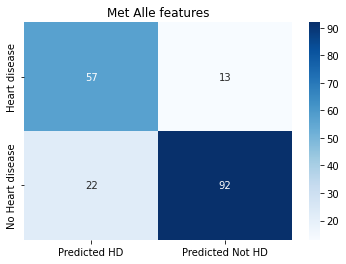

In [11]:
#Get the confusion matrix
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test, pred)
x_axis_labels = ["Predicted HD", "Predicted Not HD"] # labels for x-axis
y_axis_labels = ["Heart disease", "No Heart disease"] # labels for y-axis
sns.heatmap(cf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, cmap='Blues')
plt.title('Met Alle features')

## 8. Deployment of the model

In [13]:
import pickle

# Calculate and save the mean and standard deviation for normalization
mean = X_train[numerical_cols].mean()
std = X_train[numerical_cols].std()
normalization_stats = {'mean': mean, 'std': std}

# Save the normalization stats to a file
with open('normalization_stats.pkl', 'wb') as norm_file:
    pickle.dump(normalization_stats, norm_file)
    print('Normalization statistics saved successfully')
    
# Save the fitted encoder to a file
encoder = OneHotEncoder()
encoder.fit(X_train[categorical_cols])
with open('encoder.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)
    print('Encoder saved successfully')

# Save the model to a file
with open('heart_disease_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
    print('Model saved successfully')

Normalization statistics saved successfully
Encoder saved successfully
Model saved successfully
